In [38]:
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import os
import collections as c
sns.set()

length = 462

In [2]:
# Loading in channel 1 Data
channel_1_data = np.empty(shape=[0, length])

c1_data = glob.glob('./FINAL_DATA/normal_ex_method_0.csv')

for j in c1_data:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    channel_1_data = np.append(channel_1_data, csvrows, axis=0)

print(channel_1_data.shape)

Loading  ./FINAL_DATA/normal_ex_method_0.csv
(108876, 462)


In [3]:
# Loading in channel 2 Data
channel_2_data = np.empty(shape=[0, length])

c2_data = glob.glob('./FINAL_DATA/normal_ex_method_1.csv')

for j in c2_data:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    channel_2_data = np.append(channel_2_data, csvrows, axis=0)

print(channel_2_data.shape)

Loading  ./FINAL_DATA/normal_ex_method_1.csv
(108876, 462)


# Test Train Split

* The beat and patient hold-out methods were used for training and testing, split into 75-25%, and 90-10% respectively.


In [12]:
from sklearn.model_selection import train_test_split
# Splitting channel 1 data into train and test
train1, test1 = train_test_split(channel_1_data,test_size=0.25, stratify=channel_1_data[:,-2],random_state=48)
print(train1.shape)
print(test1.shape)

(81657, 462)
(27219, 462)


In [13]:
# Splitting channel 2 data into train and test
train2, test2 = train_test_split(channel_2_data,test_size=0.25, stratify=channel_2_data[:,-2],random_state=48)
print(train2.shape)
print(test2.shape)

(81657, 462)
(27219, 462)


# Data Resampling

* We see an abundance of ’N’ beats, while all the other beat classes do not even pass the 10,000 threshold. 
* To address the imbalance between the classes in the MIT-BIH dataset, we used the resample technique by Sci-kit Learn.
* This resampling method uses bootstrap method which estimates statistics on a data population by sampling a dataset with replacement through iteration.



# Beat Split and Resample

* For up-sampling and down-sampling, the sample value was calculated by taking the mean values of the total number of beats of the abnormal classes. 
* We can see beats with their respective annotation classes from both ECG channels.


In [10]:
from sklearn.utils import resample
# Function to resample and save the train and test split
def resample_save_train_test(train, test, channelName):
    N = train[train[:,-2]==1.0]
    L = train[train[:,-2]==2.0]
    R = train[train[:,-2]==3.0]
    V = train[train[:,-2]==4.0]
    A = train[train[:,-2]==5.0]
    F = train[train[:,-2]==6.0]
    f = train[train[:,-2]==7.0]
    I = train[train[:,-2]==8.0]

    seed=42
    np.random.seed(seed)
    def downsample(arr, n, seed):
        downsampled = resample(arr,replace=False,n_samples=n, random_state=seed)
        return downsampled

    def upsample(arr, n, seed):
        upsampled = resample(arr,replace=True,n_samples=n,random_state=seed)
        return upsampled

    all_class = [N,L,R,V,A,F,f,I]
    abn_class = [L,R,V,A,F,f,I]

    mean_val = np.mean([len(i) for i in abn_class], dtype= int)
    train_sampled = []
    # Resampling all data
    for i in all_class:
        if i.shape[0]> mean_val:
            i = downsample(i,mean_val,seed)
        elif i.shape[0]< mean_val:
            i = upsample(i,mean_val,seed)
        train_sampled.append(i)
    # Shuffling and saving the data into files    
    train_values = np.concatenate(train_sampled)
    np.random.shuffle(train_values)
    train_sampled = train_values

    with open('./train_beats_'+channelName+'.csv', "wb") as fin:
        np.savetxt(fin, train_sampled, delimiter=",", fmt='%f')

    with open('./test_beats_'+channelName+'.csv', "wb") as fin:
        np.savetxt(fin, test, delimiter=",", fmt='%f')

In [75]:
# Creating train and test split for channel 1
resample_save_train_test(train1, test1, "fc")
# Creating train and test split for channel 2
resample_save_train_test(train2, test2, "sc")

# Patient Split and Resample

* Patients that were left out for testing were: 104, 208, 213, 210, 119

In [96]:
def resample_save_patient_leaveout(data, channelName):
    patient_number = [116,106,107, 207, 231]#[104,208,113,210,119]

    indexes = np.array([], dtype=np.int64)

    for p in patient_number:
        indexes = np.append(indexes,np.where(data[:,-1]==p)[0], axis=0)
    # Seperating the train and testing data
    test_patients = data[indexes]
    train_patients = np.delete(data, indexes, axis=0)

    from sklearn.utils import resample

    N = train_patients[train_patients[:,-2]==1.0]
    L = train_patients[train_patients[:,-2]==2.0]
    R = train_patients[train_patients[:,-2]==3.0]
    V = train_patients[train_patients[:,-2]==4.0]
    A = train_patients[train_patients[:,-2]==5.0]
    F = train_patients[train_patients[:,-2]==6.0]
    f = train_patients[train_patients[:,-2]==7.0]
    I = train_patients[train_patients[:,-2]==8.0]

    seed=42
    np.random.seed(seed)
    def downsample(arr, n, seed):
        downsampled = resample(arr,replace=False,n_samples=n, random_state=seed)
        return downsampled

    def upsample(arr, n, seed):
        upsampled = resample(arr,replace=True,n_samples=n,random_state=seed)
        return upsampled

    all_class = [N,L,R,V,A,F,f,I]
    abn_class = [L,R,V,A,F,f,I]

    mean_val = np.mean([len(i) for i in abn_class], dtype= int)
    train_sampled = []
    # Resampling the data
    for i in all_class:
        if i.shape[0]> mean_val:
            i = downsample(i,mean_val,seed)
        elif i.shape[0]< mean_val:
            i = upsample(i, mean_val,seed)
        # print(i.shape)
        train_sampled.append(i)
    # Shuffling and saving the data into files
    train_sampled = np.concatenate(train_sampled)
    np.random.shuffle(train_sampled)
    train_sampled_all = train_sampled

    with open('./train_patients_'+channelName+'.csv', "wb") as fin:
        np.savetxt(fin, train_sampled_all, delimiter=",", fmt='%f')

    with open('./test_patients_'+channelName+'.csv', "wb") as fin:
        np.savetxt(fin, test_patients, delimiter=",", fmt='%f')

In [97]:
# Creating the data for first channel for patient leave-out method
resample_save_patient_leaveout(channel_1_data, "fc")
# Creating the data for second channel for patient leave-out method
resample_save_patient_leaveout(channel_2_data, "sc")

Train: (98974, 462) Test: (9902, 462)
Train: (98974, 462) Test: (9902, 462)


In [93]:
# chosen = [233,102,107, 207, 231]
# tcount = {}
# for p in chosen:
#     a = c.Counter(channel_1_data[np.where(channel_1_data[:,-1]==p)[0]][:,-2])
#     for i in list(a.keys()):
#         tcount[i] = tcount.get(i, 0) + a[i]
        
# print(tcount)

In [94]:
# labels = channel_1_data[:,-2]
# pids = list(c.Counter(channel_1_data[:,-1]).keys())
# print(pids)
# for p in pids:
#     print(p,c.Counter(channel_1_data[np.where(channel_1_data[:,-1]==p)[0]][:,-2]))

# Load Beats and Patients Split along with All Data

### Loading first channel data

In [98]:
print("Loading training beats...")
train_beats = np.genfromtxt('./train_beats_fc.csv', delimiter=',')
print("LOADED training beats...")
print("*"*40)
print("Loading testing beats...")
test_beats = np.genfromtxt('./test_beats_fc.csv', delimiter=',')  
print("LOADED testing beats...")
print("*"*40)
print("Loading training patients...")
train_patients = np.genfromtxt('./train_patients_fc.csv', delimiter=',')  
print("LOADED training patients...")
print("*"*40)
print("Loading testing patients...")
test_patients = np.genfromtxt('./test_patients_fc.csv', delimiter=',') 
print("LOADED testing patients...")

Loading training beats...
LOADED training beats...
****************************************
Loading testing beats...
LOADED testing beats...
****************************************
Loading training patients...
LOADED training patients...
****************************************
Loading testing patients...
LOADED testing patients...


# Function to plot counts

In [106]:
def plot_counts(df,name,color):
    counts = df[460].value_counts()
    plt.figure(figsize=(9,6))
    feature_names = ['N','L','R','V','A','F','f','/']
    barplt = plt.bar(counts.index, counts.values, alpha=0.8, color=color)
    plt.title(name)
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('Beat Category', fontsize=12)
    plt.xticks(ticks=[1,2,3,4,5,6,7,8],labels=feature_names)
    for bar in barplt:
      yval = bar.get_height()
      plt.text(bar.get_x()+.2, yval+60, yval)
    
    plt.show()

# Plot All Data

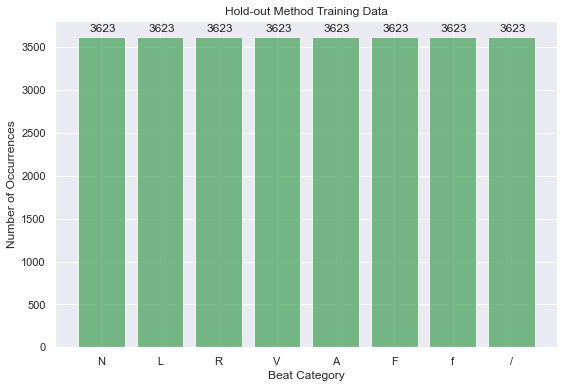

In [99]:
plot_counts(pd.DataFrame(train_beats),'Hold-out Method Training Data','g')

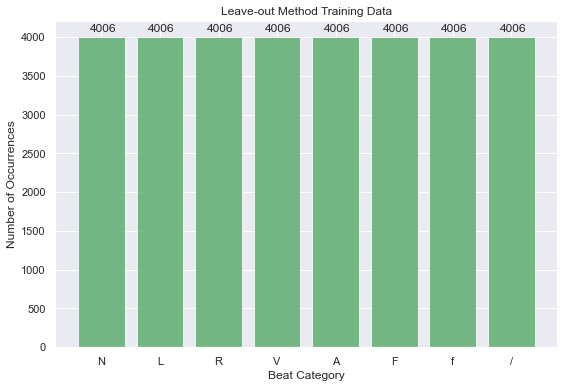

In [100]:
plot_counts(pd.DataFrame(train_patients),'Leave-out Method Training Data','g')

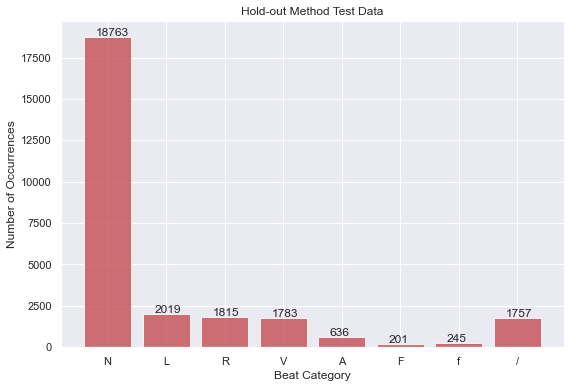

In [101]:
plot_counts(pd.DataFrame(test_beats),'Hold-out Method Test Data','r')

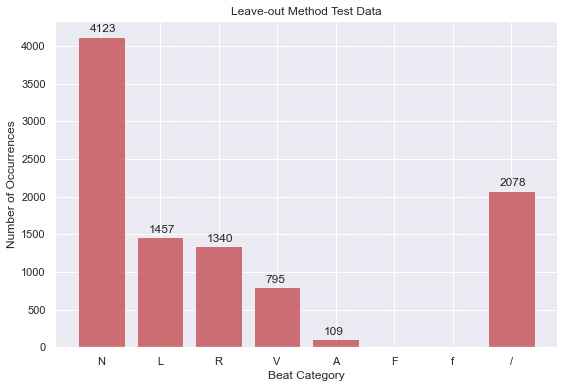

In [102]:
plot_counts(pd.DataFrame(test_patients),'Leave-out Method Test Data','r')

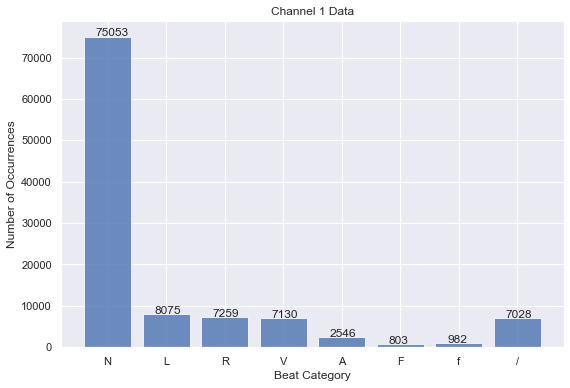

In [103]:
plot_counts(pd.DataFrame(channel_1_data),'Channel 1 Data','b')